In [73]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings

from pathlib import Path
from typing import cast

In [124]:
from cycler import cycler
colors = cycler(
    "color",
    ["#E3BA22", "#137B80", "#E6842A", "#EECC55", "#8E6C8A", "#FFBBBB"]
)

def get_color(i: int) -> str:
    return colors._left[i]["color"]

plt.style.use("classic")
plt.rc("figure", facecolor="#E5E2E0")
plt.rc(
    "axes",
    facecolor="#E5E2E0",
    edgecolor="none",
    axisbelow=True,
    grid=True,
    prop_cycle=colors,
    titlecolor="#635F5D",
)
plt.rc("grid", color="#FFFFFF", linestyle="solid")
plt.rc("xtick", direction="out", color="#8E8883")
plt.rc("ytick", direction="out", color="#8E8883")
plt.rc("lines", linewidth=1)

In [3]:
np.random.seed(1)

# Ingest data

In [4]:
data_dir = Path("../data")

In [8]:
players = pd.read_csv(data_dir /"players.csv").set_index("id")
players.head()

,first_name,second_name,now_cost,name,short_name,position
id,,,,,,
384,Tom,Heaton,40,Man Utd,MUN,GKP
385,Dean,Henderson,45,Man Utd,MUN,GKP
17,Aaron,Ramsdale,50,Arsenal,ARS,GKP
18,Rúnar Alex,Rúnarsson,40,Arsenal,ARS,GKP
28,Matt,Turner,40,Arsenal,ARS,GKP


In [22]:
def load_player_csv(filepath: Path) -> pd.DataFrame:
    player_id = int(filepath.stem.split("_")[-1])
    df = pd.read_csv(filepath)
    df["id"] = player_id
    df["year_no"] = np.arange(1, df.shape[0] + 1)
    return df

def get_historic(player_id: int, df: pd.DataFrame) -> pd.DataFrame:
    subdf = df[df["id"] == player_id]
    return subdf.sort_values(by="year_no")

In [49]:
historic = pd.concat((load_player_csv(f) for f in data_dir.glob("p_*.csv"))).join(players, on="id")
historic["delta_cost"] = historic["end_cost"] - historic["start_cost"]

players = players[players.index.to_series().apply(lambda idx: idx in historic["id"].unique())]
historic.head()

,season_name,element_code,start_cost,end_cost,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,...,expected_goals_conceded,id,year_no,first_name,second_name,now_cost,name,short_name,position,delta_cost
0,2020/21,214285,50,49,2,6,0,0,0,0,...,0.00,311,1,Konstantinos,Tsimikas,45,Liverpool,LIV,DEF,-1
1,2021/22,214285,40,37,42,874,0,2,4,6,...,0.00,311,2,Konstantinos,Tsimikas,45,Liverpool,LIV,DEF,-3
2,2022/23,214285,45,43,48,762,0,4,4,11,...,14.45,311,3,Konstantinos,Tsimikas,45,Liverpool,LIV,DEF,-2
0,2022/23,441164,50,48,59,1132,3,3,2,26,...,19.42,506,1,Pedro,Porro,50,Spurs,TOT,DEF,-2
0,2021/22,231065,45,44,90,2694,1,1,7,43,...,0.00,112,1,Ethan,Pinnock,45,Brentford,BRE,DEF,-1


In [25]:
historic.columns

Index(['season_name', 'element_code', 'start_cost', 'end_cost', 'total_points',
       'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded',
       'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards',
       'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity',
       'threat', 'ict_index', 'starts', 'expected_goals', 'expected_assists',
       'expected_goal_involvements', 'expected_goals_conceded', 'id',
       'year_no'],
      dtype='object')

# Position comparison

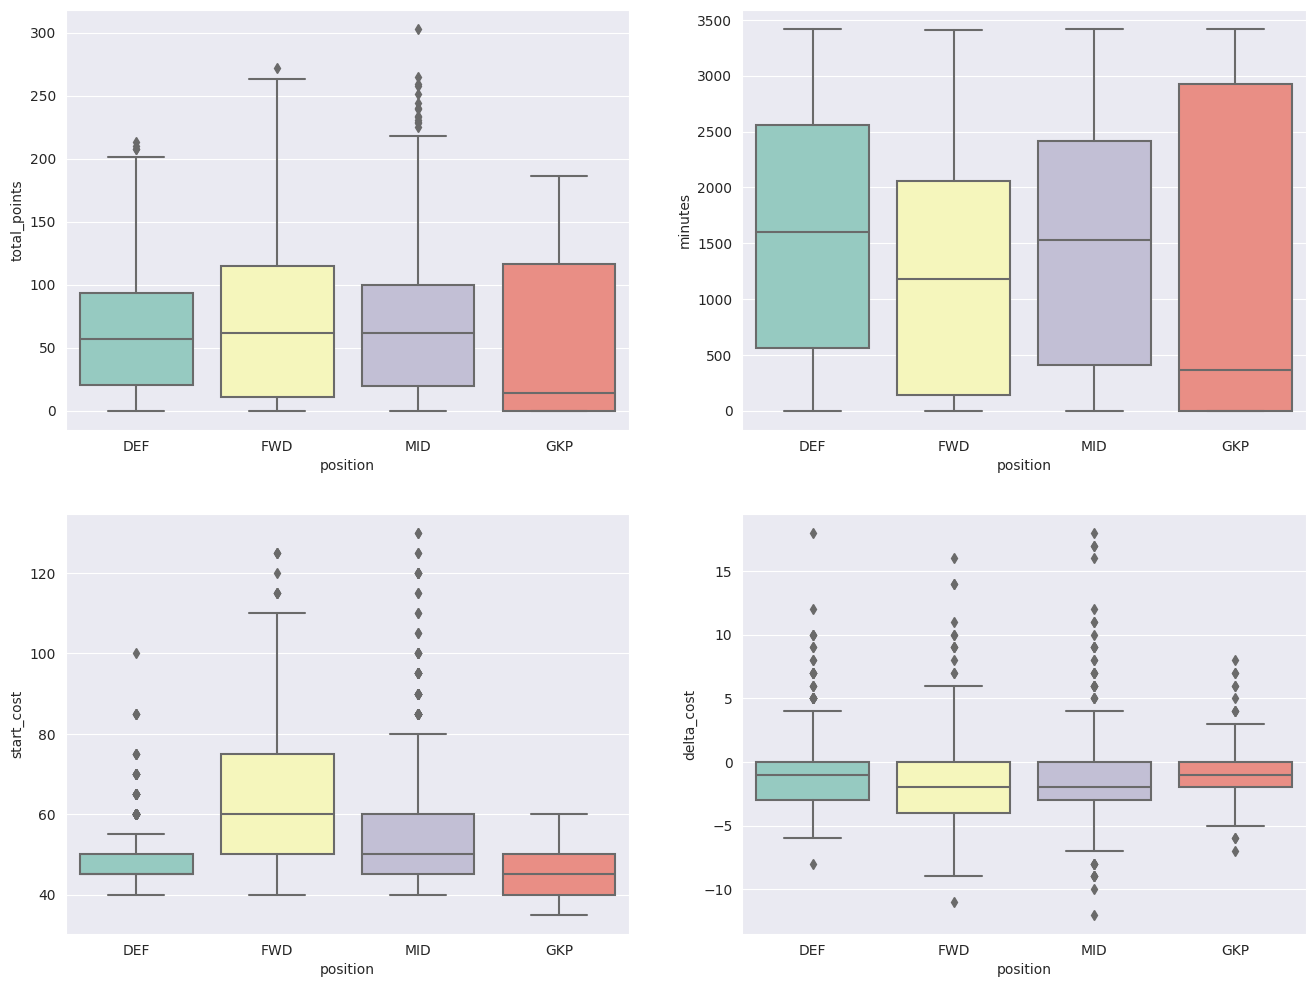

In [50]:

with sns.axes_style('darkgrid'):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    for ax, col in zip(axes.flatten(), ("total_points", "minutes", "start_cost", "delta_cost")):
        sns.boxplot(x="position", y=col, data=historic, ax=ax)

# How strongly do minutes and points correlate?

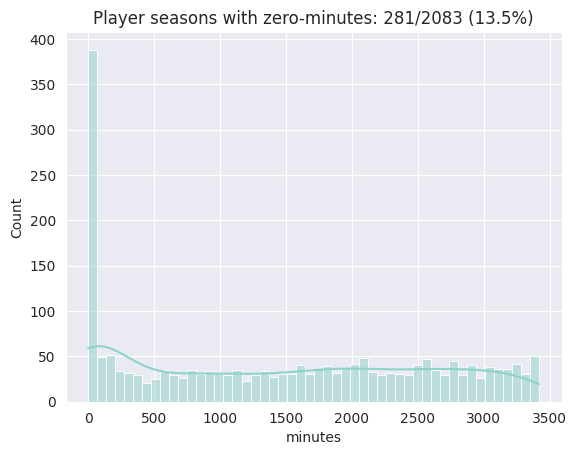

In [58]:
count_zero_mins = (historic["minutes"] == 0).sum()
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots()
    sns.histplot(historic["minutes"], bins=50, kde=True, ax=ax)
    plt.title(
        "Player seasons with zero-minutes: {cnt}/{tot} ({perc}%)".format(
            cnt=count_zero_mins,
            tot=historic.shape[0],
            perc=np.round(100*count_zero_mins/historic.shape[0], 1)
        )
    )

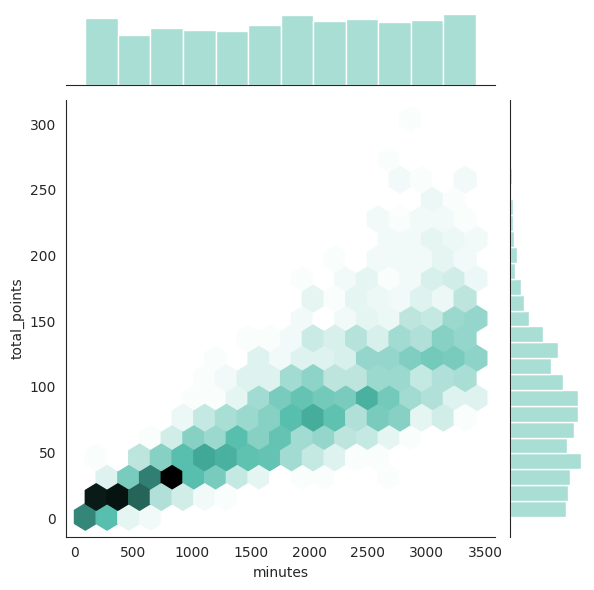

In [65]:
filter_less_than_mins = 90

with sns.axes_style("white"):
    sns.jointplot(x="minutes", y="total_points", data=historic[historic["minutes"]>filter_less_than_mins], kind="hex")

# Total Points vs Minutes

Check total points correlation with minutes played; filter out all players with less than "x" seasons.

In [87]:
seasons_required = 5
season_limit_mask = historic.groupby(by="id")["name"].count() > seasons_required
player_ids_with_season_limit = season_limit_mask.index[season_limit_mask]

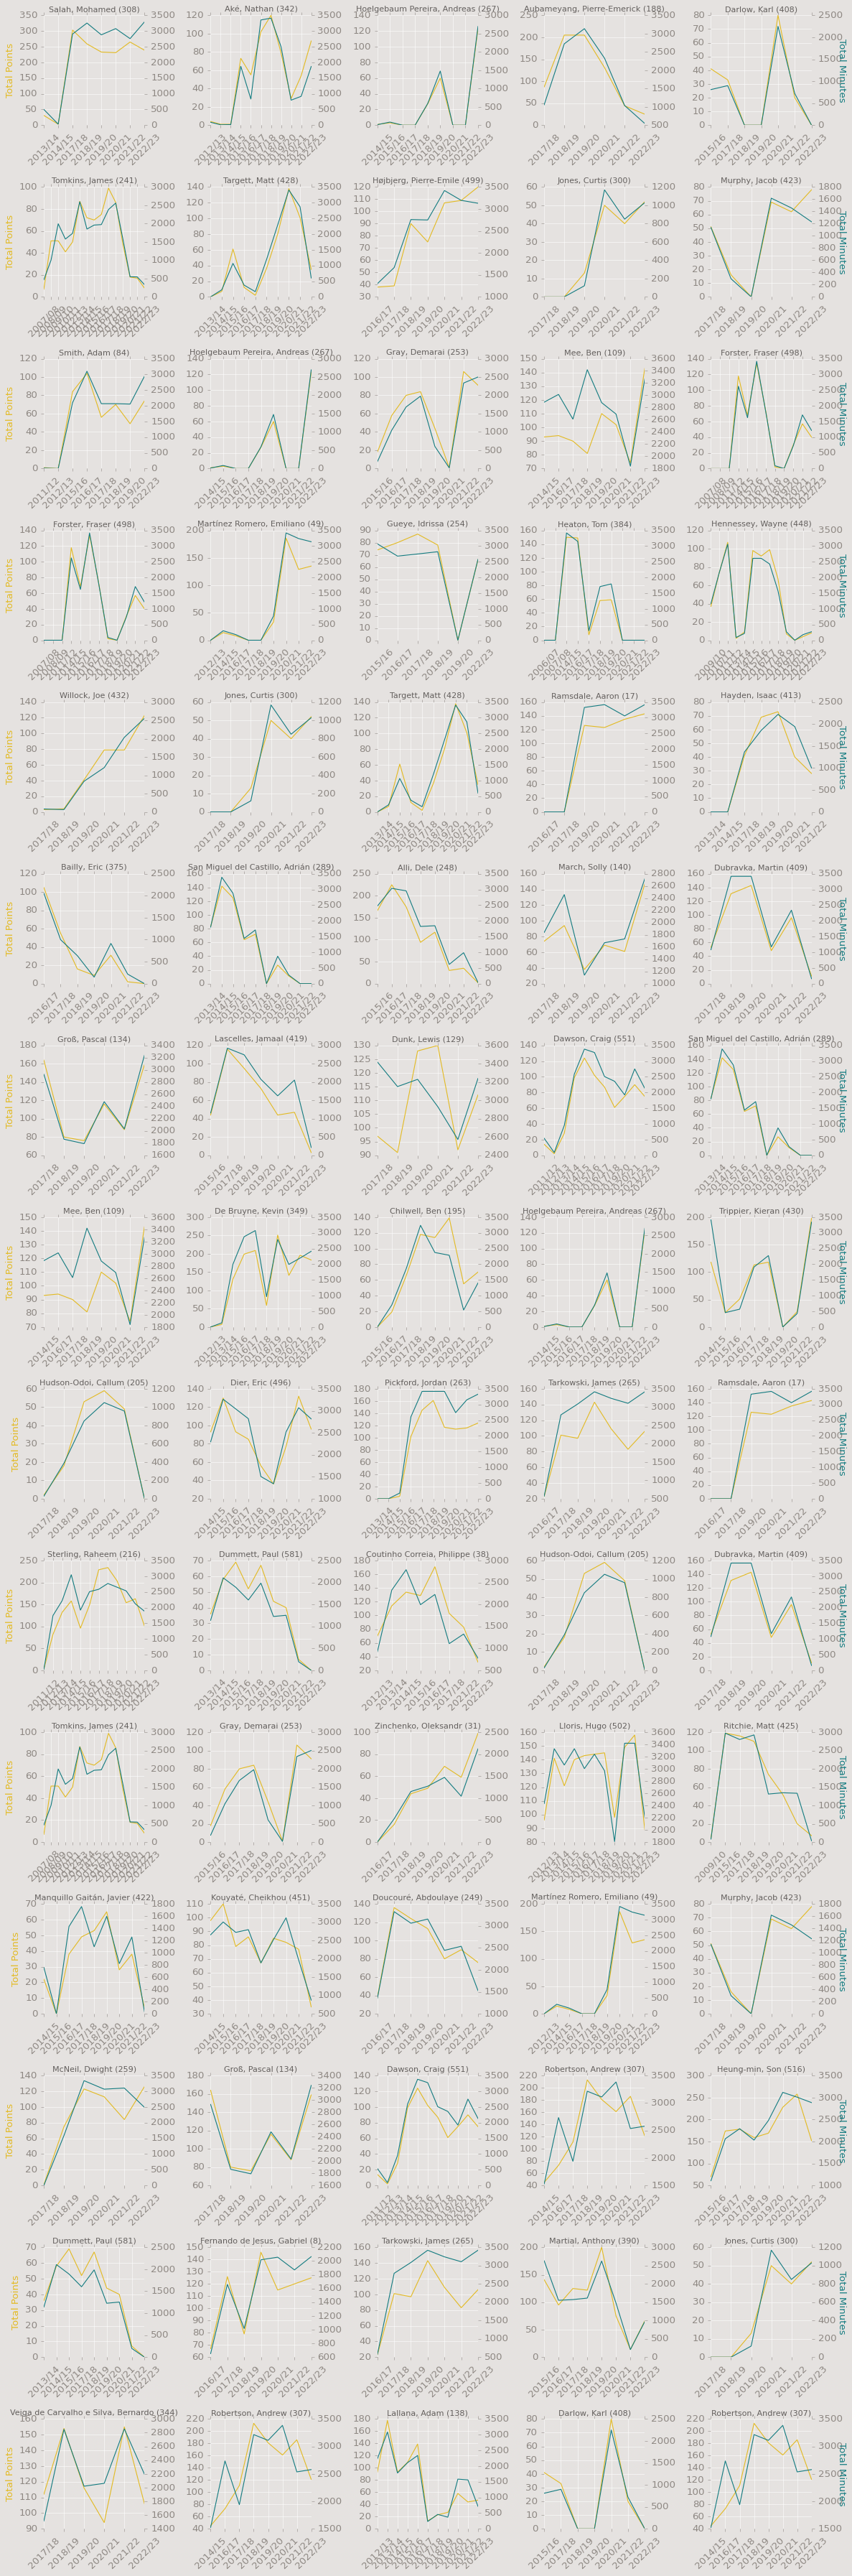

In [132]:
rows, cols = (5, 15)

random_players = np.random.choice(player_ids_with_season_limit, rows * cols)
fig, axes = plt.subplots(cols, rows, figsize=(rows*3, cols*3))

for i, player_id in enumerate(random_players):
    player_data = historic[historic["id"]==player_id]

    idx, idy = divmod(i, rows)
    ax_a = cast(plt.Axes, axes[idx, idy])
    ax_b = ax_a.twinx()
    ax_b.grid(visible=False)

    ax_a.plot("season_name", "total_points", data=player_data, c="#E3BA22")
    ax_b.plot("season_name", "minutes", data=player_data, c="#137B80")
    ax_a.set_title(
        f"{players.loc[player_id, 'second_name']}, {players.loc[player_id, 'first_name']} ({player_id})",
        fontdict={"fontsize": 10}
    )
    ax_a.tick_params(axis="x", labelrotation=45)

    if idy == 0:
        ax_a.set_ylabel("Total Points", fontdict={"color": get_color(0)})
    elif idy == rows - 1:
        ax_b.set_ylabel("Total Minutes", fontdict={"color": get_color(1), "rotation": 270})

plt.tight_layout()

# Filter out first season with low minutes (comparatively)
#### Remove breakthrough years biasing average results.

In [137]:
def iglewicz_hoaglin(s: np.ndarray[int | float]) -> np.ndarray[float]:
    """Iglewicz and Hoaglin modified Z-score."""
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        s_median = np.median(s)
        mad = np.median(np.abs(s - s_median))
        return .6745 * (s - s_median) / mad

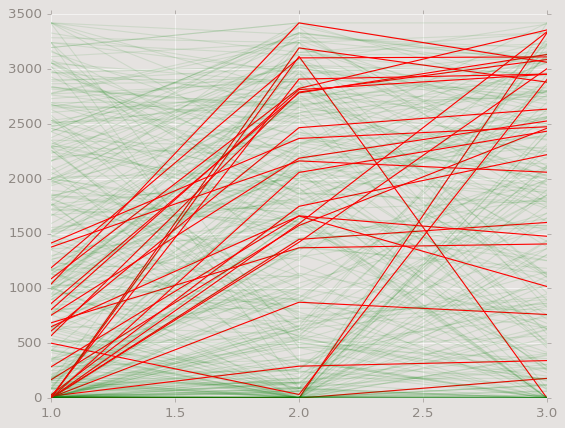

In [142]:
# Check working as expected
fig, ax = plt.subplots()
for player_id in players.index:
    player_data = historic[historic["id"] == player_id]
    zscore = iglewicz_hoaglin(player_data["minutes"])

    to_filter = False
    if list(zscore)[0] < -3.5:
        to_filter = True
    
    ax.plot(
        player_data["year_no"][:3],
        player_data["minutes"][:3],
        c = "r" if to_filter else "g",
        label = "FILTER" if to_filter else "KEEP",
        alpha=1 if to_filter else 0.1,
    )

plt.show()

# Data out

In [14]:
# Find players where first season should be filtered out
# to avoid biasing averages by breakthrough year.
p_filter_first = []
for i in players.index:
    pdata = _p[_p['id'] == i]
    zscore = iglewicz_hoaglin(pdata['minutes'])
    try:
        if list(zscore)[0] < -3.5:
            p_filter_first.append(i)
    except IndexError:
        continue
print(p_filter_first)


[352, 170, 146, 288, 429, 98, 276, 291, 309, 173, 233, 341, 406, 421, 386, 250, 255, 529]


In [15]:
# Create boolean mask and filter player data DataFrame.
# Also -=1 from all seasons, assume second season as first.
id_minseason = _p.groupby('id').min()['season_name']
_p['keep'] = True
for i, ms in id_minseason.items():
    if i in p_filter_first:
        mask_id = (_p['id']==i)
        mask_minseason = _p['season_name'] == ms
        _p.loc[_p[mask_id].index, 'season_number'] -= 1
        _p.loc[_p[mask_id & mask_minseason].index, 'keep'] = False
_p = _p[_p['keep']]

In [16]:
# Weighted average total points, biased to recent seasons.
sum_seasons = _p.groupby('id')['season_number'].transform('sum')
_p['weighted_points'] = _p['total_points'] * (1 + (_p['season_number'] / sum_seasons))

In [17]:
points = _p[['id', 'total_points', 'weighted_points']].groupby('id').mean()
points.head()

,total_points,weighted_points
id,,
1,117.000,157.388889
2,1.000,2.000000
3,114.875,129.628472
4,157.000,197.900000
5,69.000,78.730159


117.0
157.38888888888889


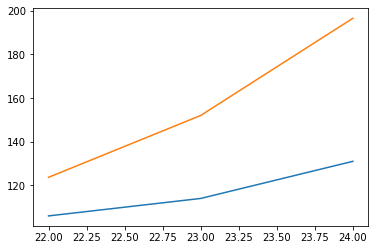

In [18]:
#  Checking...
fig, ax = plt.subplots()
i = 1
_ = _p[(_p['id'] == i)]
ax.plot(_['total_points'])
ax.plot(_['total_points'] * (1 + (_['season_number'] / _['season_number'].sum())))
print(_['total_points'].mean())
print((_['total_points'] * (1 + (_['season_number'] / _['season_number'].sum()))).mean())

In [19]:
players.join(points, how='inner').rename(
    columns={'short_name': 'club'}
    ).to_csv('../data/player_points.csv')